In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Module Installs

In [3]:
%pip install adjustText

In [4]:
import pandas as pd
import numpy as np
import math as math
import random
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV
import sklearn.preprocessing  as skp
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn import metrics
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
import matplotlib.lines as mlines
from adjustText import adjust_text
import shap

#constants
random_state = 42
plotColor = ['b','g','r','m','c', 'y']
markers = ['+','o','*','^','v','>','<']


In [5]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
def data_transformations(df_raw):
    """ Rename column names and transformed into proper format and return dataframe """
    df_tf = df.copy()

    df_tf.rename(columns={'gender':'Gender'
                       ,'customerID':'CustomerID'
                       ,'Contract':'ContractType'
                       ,'InternetService':'InternetServiceType'
                       ,'tenure':'Tenure'
                      }
              ,inplace=True)


    df_tf['Partner'] = df_tf.Partner.map({'Yes':1,'No':0})
    df_tf['Dependents'] = df_tf.Dependents.map({'Yes':1,'No':0})

    df_tf['PhoneService'] = df_tf.PhoneService.map({'Yes':1,'No':0})
    df_tf['MultipleLines'] = df_tf.MultipleLines.map({'Yes':1,'No':0,'No phone service':0})

    df_tf['InternetService'] = df_tf.InternetServiceType.map({'DSL':1,'Fiber optic':2,'No':0})
    df_tf['OnlineSecurity'] = df_tf.OnlineSecurity.map({'Yes':1,'No':0,'No internet service':0})
    df_tf['OnlineBackup'] = df_tf.OnlineBackup.map({'Yes':1,'No':0,'No internet service':0})
    df_tf['DeviceProtection'] = df_tf.DeviceProtection.map({'Yes':1,'No':0,'No internet service':0})
    df_tf['TechSupport'] = df_tf.TechSupport.map({'Yes':1,'No':0,'No internet service':0})
    df_tf['StreamingTV'] = df_tf.StreamingTV.map({'Yes':1,'No':0,'No internet service':0})
    df_tf['StreamingMovies'] = df_tf.StreamingMovies.map({'Yes':1,'No':0,'No internet service':0})
    df_tf['PaperlessBilling'] = df_tf.PaperlessBilling.map({'Yes':1,'No':0})
    df_tf['Churn'] = df_tf.Churn.map({'Yes':1,'No':0})

    # Data mining
    df_tf['IsContracted'] = df_tf.ContractType.map({'One year':1,'Two year':1,'Month-to-month':0})

    # Data transformation

    # Converting TotalCharges into Numeric, but some of the records are empty, so first we need to deal with them.
    df_tf.loc[df_tf['TotalCharges']==' ','TotalCharges'] = np.nan

    # First we convert TotalCharges to float and then replace with tenure * monthly charges
    df_tf['TotalCharges'] = df_tf['TotalCharges'].astype('float64')
    df_tf.loc[df_tf['TotalCharges'].isnull()==True,'TotalCharges'] = df_tf['MonthlyCharges'] * df_tf['Tenure']


    return df_tf

In [7]:
df_cal = data_transformations(df)
df_cal.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetServiceType,OnlineSecurity,...,StreamingTV,StreamingMovies,ContractType,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetService,IsContracted
0,7590-VHVEG,Female,0,1,0,1,0,0,DSL,0,...,0,0,Month-to-month,1,Electronic check,29.85,29.85,0,1,0
1,5575-GNVDE,Male,0,0,0,34,1,0,DSL,1,...,0,0,One year,0,Mailed check,56.95,1889.50,0,1,1
2,3668-QPYBK,Male,0,0,0,2,1,0,DSL,1,...,0,0,Month-to-month,1,Mailed check,53.85,108.15,1,1,0
3,7795-CFOCW,Male,0,0,0,45,0,0,DSL,1,...,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,1,1
4,9237-HQITU,Female,0,0,0,2,1,0,Fiber optic,0,...,0,0,Month-to-month,1,Electronic check,70.70,151.65,1,2,0


In [8]:
categorical_col = ["Gender","Partner","Dependents","SeniorCitizen","PhoneService","MultipleLines"
                    ,"InternetServiceType","OnlineSecurity","OnlineBackup","DeviceProtection"
                    ,"TechSupport","StreamingTV","StreamingMovies","IsContracted"
                    ,"ContractType","PaperlessBilling","PaymentMethod"]


numerical_col = ["Tenure","MonthlyCharges","TotalCharges"]

target_col = 'Churn'

# spliting categorical columns into Nominal and Binary columns

nominal_col = ['Gender','InternetServiceType','PaymentMethod','ContractType']

binary_col = ['SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity'
               ,'OnlineBackup' ,'DeviceProtection','TechSupport','StreamingTV', 'StreamingMovies'
               ,'PaperlessBilling','InternetService', 'IsContracted']

In [9]:
df_cal[categorical_col].describe(include='all')


,Gender,Partner,Dependents,SeniorCitizen,PhoneService,MultipleLines,InternetServiceType,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,IsContracted,ContractType,PaperlessBilling,PaymentMethod
count,7043,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043,7043.000000,7043
unique,2,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,4
top,Male,NaN,NaN,NaN,NaN,NaN,Fiber optic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Month-to-month,NaN,Electronic check
freq,3555,NaN,NaN,NaN,NaN,NaN,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3875,NaN,2365
mean,NaN,0.483033,0.299588,0.162147,0.903166,0.421837,NaN,0.286668,0.344881,0.343888,0.290217,0.384353,0.387903,0.449808,NaN,0.592219,NaN
std,NaN,0.499748,0.458110,0.368612,0.295752,0.493888,NaN,0.452237,0.475363,0.475038,0.453895,0.486477,0.487307,0.497510,NaN,0.491457,NaN
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN
25%,NaN,0.000000,0.000000,0.000000,1.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN
50%,NaN,0.000000,0.000000,0.000000,1.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,NaN
75%,NaN,1.000000,1.000000,0.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,NaN


In [10]:
df_cal[numerical_col].describe()

,Tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


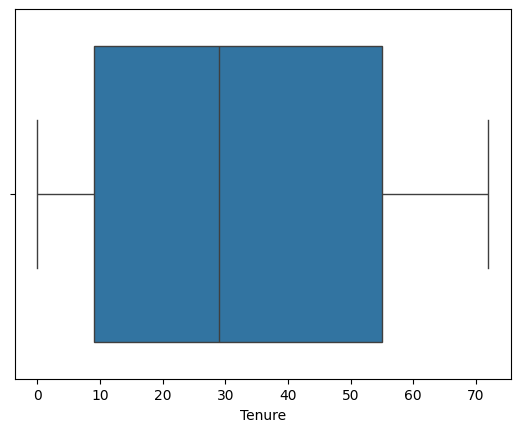

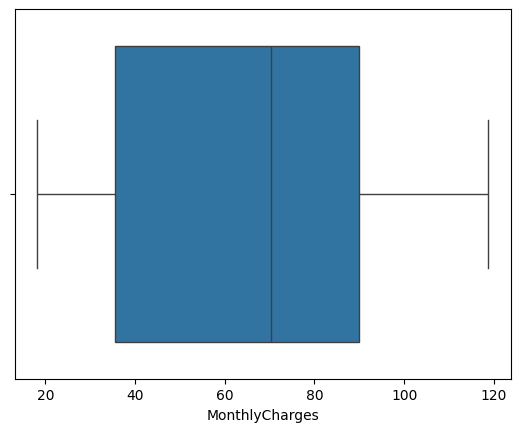

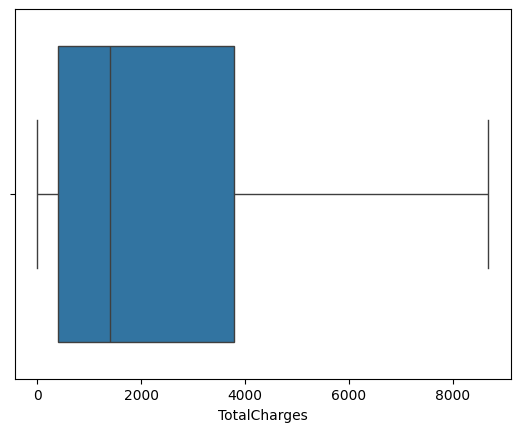

In [11]:
for i in numerical_col:
  sns.boxplot(x=df_cal[i])
  plt.show()


In [12]:
Churn_rate = df_cal['Churn'].value_counts() / df_cal.shape[0]
fig = go.Figure(
    go.Bar(
        x=Churn_rate.index.map({0:'Existing',1:"Churn"}), y=Churn_rate.values,
        marker_color="steelblue", opacity=0.6, text=[f"{v*100:.2f}%" for v in Churn_rate.values], textposition="outside"
    )
)

    # Layout & axes (preserve x order, hide y ticks, only bottom line visible)
fig.update_layout(
    title='Customer Distribution',
    xaxis_title='Customers',
    yaxis_title='Percentage',
    bargap=0.25,                  # ~bar width 0.75 equivalent
    margin=dict(l=40, r=20, t=60, b=40),
)
fig.update_xaxes(
    categoryorder="array",        # prevent alphabetical sorting
    categoryarray=list(Churn_rate.index.map({0:'Existing',1:"Churn"})),
    showgrid=False,
    showline=True,                # bottom axis line
    linecolor="black",
    ticks=""
)
fig.update_yaxes(
    range=[0, 1],                 # same as plt.ylim(top=1)
    showgrid=False,
    showticklabels=False,
    showline=False
)

    # Let text render a bit outside the plotting area if needed
fig.update_traces(cliponaxis=False)
fig.show()

In [13]:
# 1. Compute correlation (rounded)
var_corr = round(df_cal[binary_col].corr(), 2)

# 2. Create mask for upper triangle
mask = np.triu(np.ones_like(var_corr, dtype=bool))
corr_masked = var_corr.mask(mask)   # set upper-triangle values to NaN

# 3. Build Plotly heatmap
fig = go.Figure(
    data=go.Heatmap(
        z=corr_masked.values,
        x=corr_masked.columns,
        y=corr_masked.index,
        colorscale="YlOrBr",
        zmin=-1, zmax=1,
        colorbar=dict(title="Correlation"),
        text=np.where(mask, "", var_corr.values.round(2).astype(str)),  # annotations
        texttemplate="%{text}",
        hoverongaps=False
    )
)

# 4. Layout formatting
fig.update_layout(
    title="Correlation Heatmap",
    width=800, height=800,
    xaxis=dict(side="bottom")  # put labels on top
)

fig.show()

In [14]:
# create subplot grid
rows = len(categorical_col)
fig = make_subplots(
    rows=rows, cols=1,
    subplot_titles=[f"{feature} Distribution by Churn" for feature in categorical_col]
)

# loop through features and add traces
for i, feature in enumerate(categorical_col, start=1):
    # calculate percentages
    feature_summary = (
        df_cal.groupby("Churn")[feature]
        .value_counts(normalize=True)
        .reset_index(name="Percentage")
    )

    # add bars for each churn category
    for churn_value in feature_summary["Churn"].unique():
        subset = feature_summary[feature_summary["Churn"] == churn_value]
        fig.add_trace(
            go.Bar(
                x=subset[feature],
                y=subset["Percentage"],
                name=f"Churn={churn_value}",
                text=[f"{p*100:.2f}%" for p in subset["Percentage"]],
                textposition="outside",
                opacity=0.7
            ),
            row=i, col=1
        )

# formatting
fig.update_yaxes(range=[0, 1], title="Percentage")
fig.update_layout(
    height=350*rows,  # scale with number of features
    width=900,
    showlegend=False,
    title_text="Categorical Variable Distributions by Churn",
    barmode="group"  # side by side
)

fig.show()

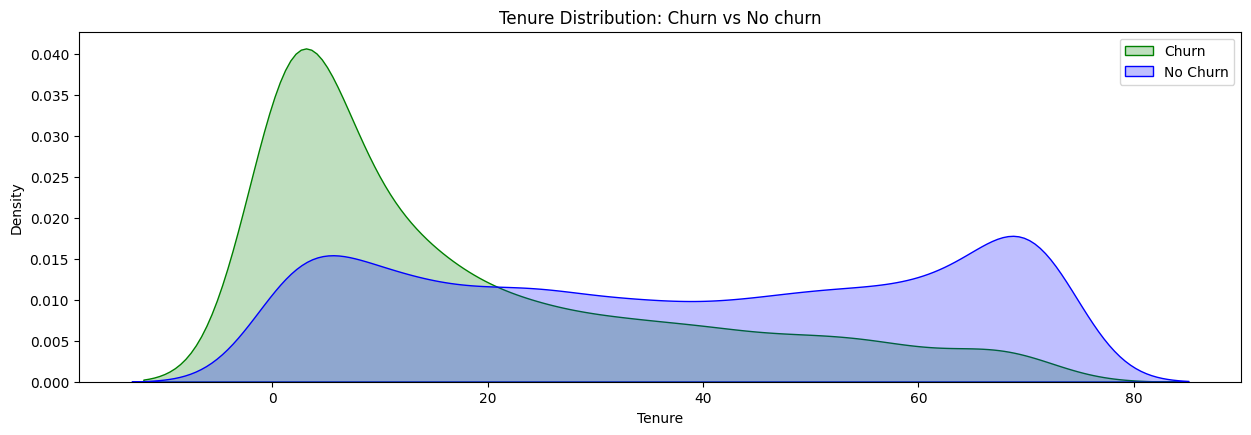

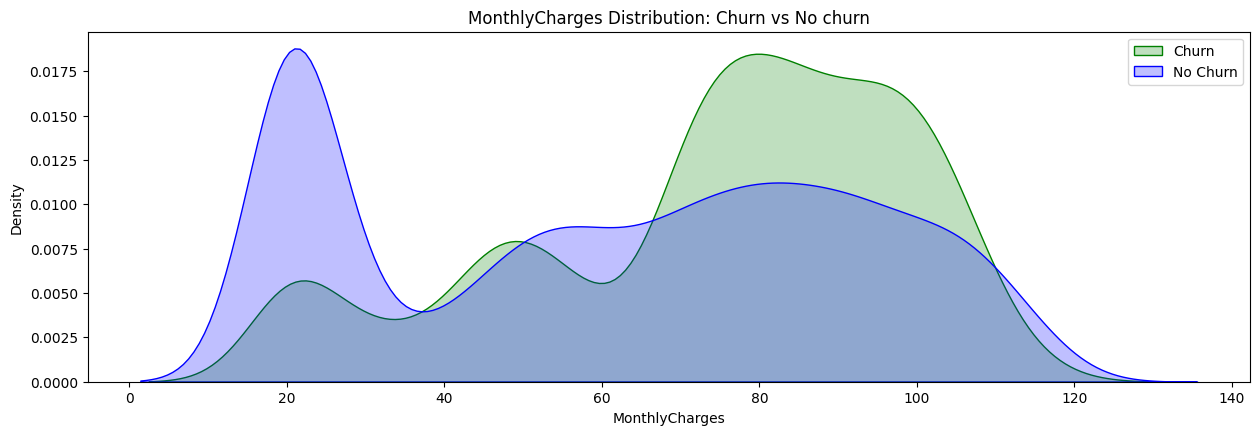

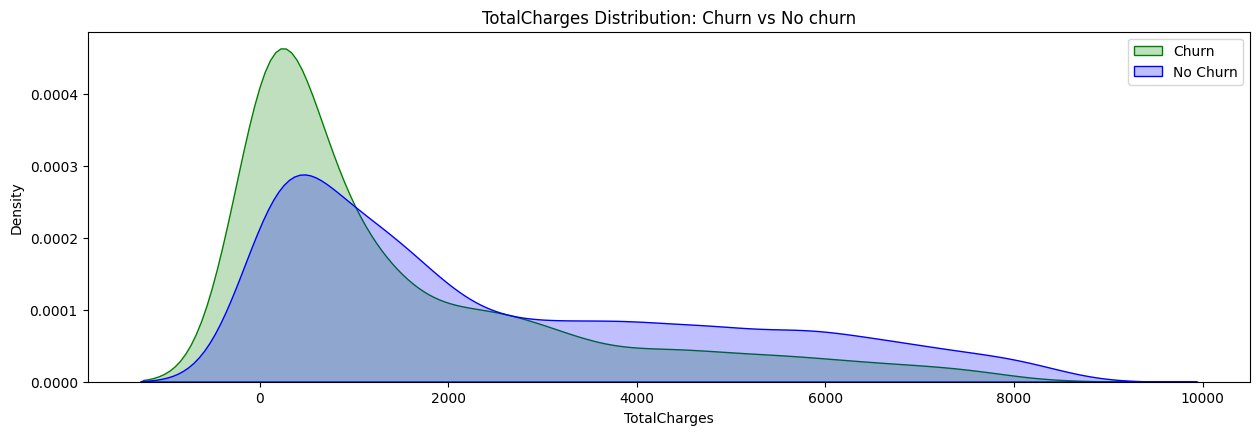

In [15]:
num_features = ['Tenure','MonthlyCharges','TotalCharges']

for f in num_features:
  fig = plt.figure(figsize=(15,10))
  plt.subplot(2,1,2)
  ax = sns.kdeplot(df_cal.loc[(df_cal['Churn']==1), f]
                     , color = 'g'
                     , fill = True
                     , label='Churn'
                     , legend = True)
  ax = sns.kdeplot(df_cal.loc[(df_cal['Churn']==0), f]
                     , color = 'b'
                     , fill = True
                     , label='No Churn'
                     , legend = True)
  title_str = f + " Distribution: Churn vs No churn"
  plt.title(title_str)
  plt.legend()
  plt.show()

From above distribution, churn subscribers are

1.   Likely to leave company who's tenure is less than a year
2.   Likely to have more than $65 monthly charges

In [16]:
df_cal.groupby('Churn')[['Tenure', 'MonthlyCharges', 'TotalCharges']].mean()

,Tenure,MonthlyCharges,TotalCharges
Churn,,,
0,37.569965,61.265124,2549.911442
1,17.979133,74.441332,1531.796094


In [17]:
df_cal['Tenure_norm'] = skp.StandardScaler().fit_transform(df_cal[['Tenure']])
df_cal['MonthlyCharges_norm'] = skp.StandardScaler().fit_transform(df_cal[['MonthlyCharges']])
df_cal.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetServiceType,OnlineSecurity,...,ContractType,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetService,IsContracted,Tenure_norm,MonthlyCharges_norm
0,7590-VHVEG,Female,0,1,0,1,0,0,DSL,0,...,Month-to-month,1,Electronic check,29.85,29.85,0,1,0,-1.277445,-1.160323
1,5575-GNVDE,Male,0,0,0,34,1,0,DSL,1,...,One year,0,Mailed check,56.95,1889.50,0,1,1,0.066327,-0.259629
2,3668-QPYBK,Male,0,0,0,2,1,0,DSL,1,...,Month-to-month,1,Mailed check,53.85,108.15,1,1,0,-1.236724,-0.362660
3,7795-CFOCW,Male,0,0,0,45,0,0,DSL,1,...,One year,0,Bank transfer (automatic),42.30,1840.75,0,1,1,0.514251,-0.746535
4,9237-HQITU,Female,0,0,0,2,1,0,Fiber optic,0,...,Month-to-month,1,Electronic check,70.70,151.65,1,2,0,-1.236724,0.197365


In [18]:
df_model = data_transformations(df)
df_model.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetServiceType,OnlineSecurity,...,StreamingTV,StreamingMovies,ContractType,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetService,IsContracted
0,7590-VHVEG,Female,0,1,0,1,0,0,DSL,0,...,0,0,Month-to-month,1,Electronic check,29.85,29.85,0,1,0
1,5575-GNVDE,Male,0,0,0,34,1,0,DSL,1,...,0,0,One year,0,Mailed check,56.95,1889.50,0,1,1
2,3668-QPYBK,Male,0,0,0,2,1,0,DSL,1,...,0,0,Month-to-month,1,Mailed check,53.85,108.15,1,1,0
3,7795-CFOCW,Male,0,0,0,45,0,0,DSL,1,...,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,1,1
4,9237-HQITU,Female,0,0,0,2,1,0,Fiber optic,0,...,0,0,Month-to-month,1,Electronic check,70.70,151.65,1,2,0


In [19]:
# Step 1: Merge dataframe with selected features
features = [categorical_col, numerical_col, target_col]
merged_df = pd.DataFrame()
for feature in features:
    merged_df = pd.concat([merged_df, df_model[feature]], axis=1)

# Step 2: Shuffle the data
merged_df = shuffle(merged_df).reset_index(drop=True)

# Step 3: One-hot encode nominal columns
merged_df = pd.concat([merged_df, pd.get_dummies(merged_df[nominal_col])], axis=1)
merged_df.drop(nominal_col, axis=1, inplace=True)

# Step 4: Normalize numerical columns
for col in numerical_col:
    merged_df[col] = skp.StandardScaler().fit_transform(merged_df[[col]])

# Step 5: Split features and target
feature_cols = merged_df.columns.difference([target_col])
X = merged_df[feature_cols]
y = merged_df[target_col].values.flatten()

# Step 6: Split into train and test
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)

# Step 7: Print shapes
print("Original features shape:", X.shape)
print("Original target shape:", y.shape)
print("x train shape:", x_train.shape)
print("y train shape:", y_train.shape)
print("x test shape:", x_test.shape)
print("y test shape:", y_test.shape)

Original features shape: (7043, 28)
Original target shape: (7043,)
x train shape: (5634, 28)
y train shape: (5634,)
x test shape: (1409, 28)
y test shape: (1409,)


In [20]:
# Upsampling using SMOTE
sm = SMOTE(random_state = random_state
           , sampling_strategy = 1.0)
x_train_sm , y_train_sm = sm.fit_resample(x_train,y_train)

print("Original x train shape, ", x_train.shape)
print("Resample x train shape, ", x_train_sm.shape)

Original x train shape,  (5634, 28)
Resample x train shape,  (8264, 28)


In [21]:
clsModelsNm = ["Logistic Regression", "Random Forest", "Gradient boosting", "Decision Trees"]
scoreMatrix = ['accuracy','precision','recall','f1','neg_log_loss']

clsParams = {'Logistic Regression':{'C':[0.1, 0.5, 1, 5, 10, 15, 20, 100]
                                   ,'penalty':['l2']
                                    }
             , 'Random Forest': {'max_depth':[3,5,7,10,15,20]
                                ,'n_estimators':[100,150,200]
                                ,'max_features':['sqrt', 'log2', 0.7,0.2]
                                ,'min_samples_leaf':[1,5,10,15,20]
                                 }
             , 'Gradient boosting': {'learning_rate': [0.05, 0.1, 0.2]
                                    ,'n_estimators':[10,50,100,150,200]
                                    ,'max_depth':[3,5,7]
                                    ,'min_samples_split':[0.1, 0.5, 1.0]
                                    ,'min_samples_leaf':[1, 5, 10, 15, 20]
                                    ,'subsample': [0.1, 0.5, 0.7 , 1]
                                    }
             , 'Decision Trees': {'criterion': ['gini', 'entropy', 'log_loss']  # log_loss available in sklearn >=1.1
                                ,'max_depth': [3, 5, 7, 10, 15, 20, None]     # None = expand fully
                                ,'min_samples_split': [2, 5, 10, 20]
                                ,'min_samples_leaf': [1, 5, 10, 20]
                                , 'max_features': ['sqrt', 'log2', None]
                              }
            }

In [22]:
def Parameter_tunning(x, y, models, clsModelsNm, parameters, score):

    tuned_params = {}
    for i,model in enumerate(models):
        print(clsModelsNm[i])
        grid = RandomizedSearchCV(estimator = model
                            , cv = 5
                            , param_distributions = parameters[clsModelsNm[i]]
                            , scoring = score
                            , n_jobs = 3
                            , n_iter = 150)
        grid.fit(x,y)
        print(grid.best_score_)
        print(grid.best_params_)
        tuned_params[clsModelsNm[i]] = {'params':grid.best_params_}

    return tuned_params

In [23]:
clsLR = LogisticRegression(random_state = random_state)
clsRF = RandomForestClassifier(random_state = random_state)
clsGB = GradientBoostingClassifier(random_state = random_state)
clsDT = DecisionTreeClassifier(random_state=random_state)

clsModels = [clsLR, clsRF, clsGB, clsDT]

tuned_params = Parameter_tunning(x_train, y_train, clsModels, clsModelsNm, clsParams, 'neg_log_loss')


Logistic Regression


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning:

The total space of parameters 8 is smaller than n_iter=150. Running 8 iterations. For exhaustive searches, use GridSearchCV.



-0.4205438625392076
{'penalty': 'l2', 'C': 0.5}
Random Forest
-0.4180588618262636
{'n_estimators': 150, 'min_samples_leaf': 15, 'max_features': 'log2', 'max_depth': 20}
Gradient boosting
-0.4139084446497203
{'subsample': 1, 'n_estimators': 150, 'min_samples_split': 1.0, 'min_samples_leaf': 10, 'max_depth': 7, 'learning_rate': 0.2}
Decision Trees
-0.4399752958790607
{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 3, 'criterion': 'log_loss'}


In [24]:
clsLR_sm = LogisticRegression(random_state = random_state)
clsRF_sm = RandomForestClassifier(random_state = random_state)
clsGB_sm = GradientBoostingClassifier(random_state = random_state)
clsDT_sm = DecisionTreeClassifier(random_state=random_state)

clsModels_sm = [clsLR_sm, clsRF_sm, clsGB_sm, clsDT_sm]

tuned_params_sm = Parameter_tunning(x_train_sm, y_train_sm, clsModels_sm, clsModelsNm, clsParams , 'neg_log_loss')

Logistic Regression


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning:

The total space of parameters 8 is smaller than n_iter=150. Running 8 iterations. For exhaustive searches, use GridSearchCV.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



-0.40105738155822995
{'penalty': 'l2', 'C': 10}
Random Forest
-0.36440065644258623
{'n_estimators': 200, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 15}
Gradient boosting
-0.38581815131910757
{'subsample': 1, 'n_estimators': 100, 'min_samples_split': 0.1, 'min_samples_leaf': 5, 'max_depth': 7, 'learning_rate': 0.2}
Decision Trees
-0.48739103193952255
{'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 5, 'criterion': 'gini'}


In [25]:
def plot_precision_recall_vs_thresold(precisions, recalls, thresholds):
    plt.plot(thresholds,precisions[:-1],label="Precision")
    plt.plot(thresholds,recalls[:-1],label="Recall")
    plt.plot(thresholds,2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1]+recalls[:-1]) ,label="F1")
    plt.title("Precision, recall & F1 vs thresold")
    plt.xlabel("Thresold")
    plt.legend(loc='lower right')
    plt.show()

In [26]:
def Cross_validation_score(clsModels, clsModelsNm, clsSample, scoreMatrix):
    """ Cross validation using cross_val_score method """
    for i,model in enumerate(clsModels):
        print("===============================================")
        print(clsModelsNm[i])

        for j, sample in enumerate(clsSample):
            print("************************************************")
            print(sample[2])

            for score in scoreMatrix:
                scores = cross_val_score(model, sample[0], sample[1], cv=5 , scoring = score)
                print(score, " score:", scores.mean())

            y_scores = cross_val_predict(model, sample[0], sample[1], cv=5, method="predict_proba")


            precisions, recalls, thresholds = metrics.precision_recall_curve(sample[1], y_scores[:][:,1])
            plot_precision_recall_vs_thresold(precisions, recalls, thresholds)
            score_matrix = pd.DataFrame({'Precisions': precisions[:-1]
                                ,'Recalls': recalls[:-1]
                                ,'F1': 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1]+recalls[:-1])
                                ,'Threshold': thresholds
                               })
            #print("When percision and recall are same \n" , score_matrix[ score_matrix['Precisions'] == score_matrix['Recalls']] )
            print("When F1 score is max \n" , score_matrix[ score_matrix['F1'] == max(score_matrix['F1'])] )

Logistic Regression
************************************************
Original data
accuracy  score: 0.8012105575877737
precision  score: 0.6508218117505606
recall  score: 0.5479579180509413
f1  score: 0.5948630039381844
neg_log_loss  score: -0.4205438625392076


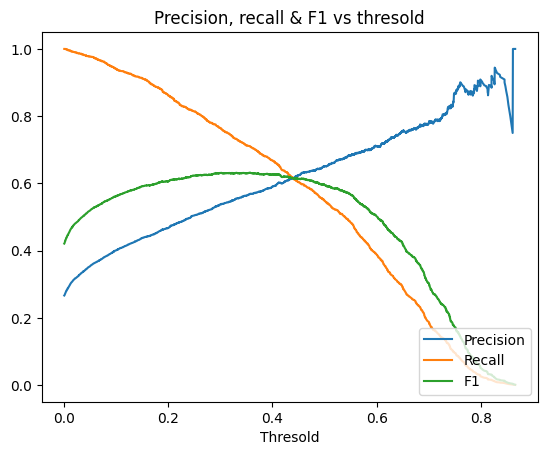

When F1 score is max 
       Precisions   Recalls        F1  Threshold
3759     0.56937  0.710386  0.632109   0.357384
Random Forest
************************************************
Original data
accuracy  score: 0.8012089815461284
precision  score: 0.6700153692437457
recall  score: 0.5006755260243632
f1  score: 0.5729104675281284
neg_log_loss  score: -0.41869421171986587


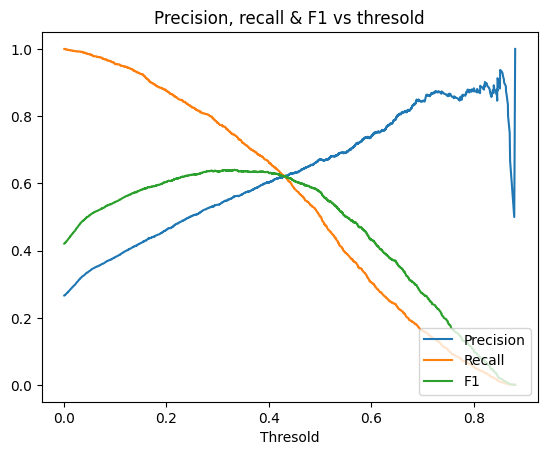

When F1 score is max 
       Precisions   Recalls        F1  Threshold
3635    0.561809  0.744341  0.640321   0.332614
Gradient boosting
************************************************
Original data
accuracy  score: 0.8028070877744874
precision  score: 0.6624996947023272
recall  score: 0.5306511627906977
f1  score: 0.5890327090654486
neg_log_loss  score: -0.4144015893108498


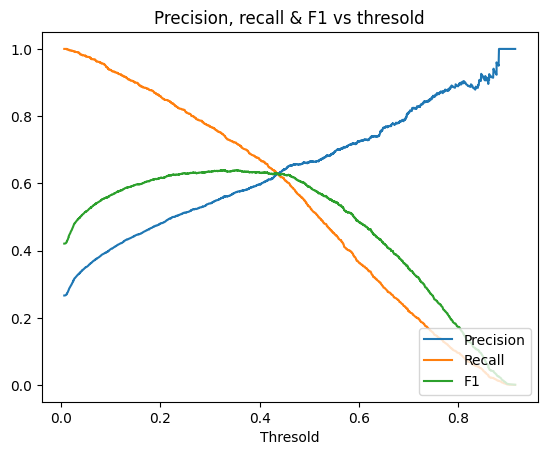

When F1 score is max 
       Precisions   Recalls        F1  Threshold
3352    0.560963  0.744341  0.639771   0.327564
Decision Trees
************************************************
Original data
accuracy  score: 0.7871877270484994
precision  score: 0.6725019619664533
recall  score: 0.393483942414175
f1  score: 0.49553809893988765
neg_log_loss  score: -0.4399752958790607


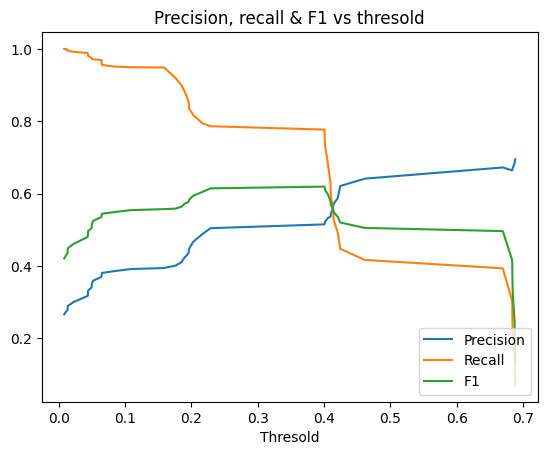

When F1 score is max 
     Precisions   Recalls        F1  Threshold
25    0.515004  0.776964  0.619427   0.400616


In [27]:
clsLR = LogisticRegression(random_state = random_state
                           , C = 0.5
                           , penalty = 'l2')

clsRF = RandomForestClassifier(random_state = random_state
                              ,max_depth = 10
                              ,max_features = 0.2
                              ,min_samples_leaf = 20
                              ,n_estimators = 200 )


clsGB = GradientBoostingClassifier(random_state = random_state
                              , max_depth = 3
                              , n_estimators = 150
                              , learning_rate = 0.1
                              , min_samples_leaf = 20
                              , min_samples_split = 0.5
                              , subsample = 0.7)

clsDT = DecisionTreeClassifier(min_samples_split = 10
                               , min_samples_leaf = 1
                               , max_features = None
                               , max_depth = 3
                               , criterion = 'log_loss')


clsModels = [clsLR, clsRF, clsGB, clsDT]

Cross_validation_score(clsModels, clsModelsNm, [(x_train, y_train,'Original data')], scoreMatrix)

Logistic Regression
************************************************
Upsampled data


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



accuracy  score: 0.8141381361058988


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



precision  score: 0.8031201614071138


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



recall  score: 0.8292134995944969


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



f1  score: 0.8118859126321215


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



neg_log_loss  score: -0.40105738155822995


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



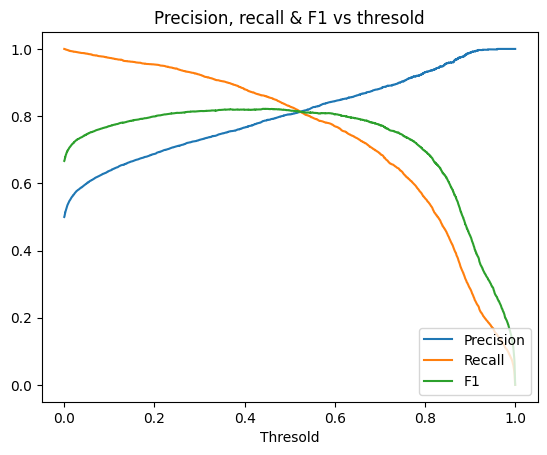

When F1 score is max 
       Precisions   Recalls        F1  Threshold
3770    0.789134  0.857696  0.821988   0.451203
Random Forest
************************************************
Upsampled data
accuracy  score: 0.8429363883115151
precision  score: 0.8127907470323331
recall  score: 0.8904090457940395
f1  score: 0.8487685011218735
neg_log_loss  score: -0.36440065644258623


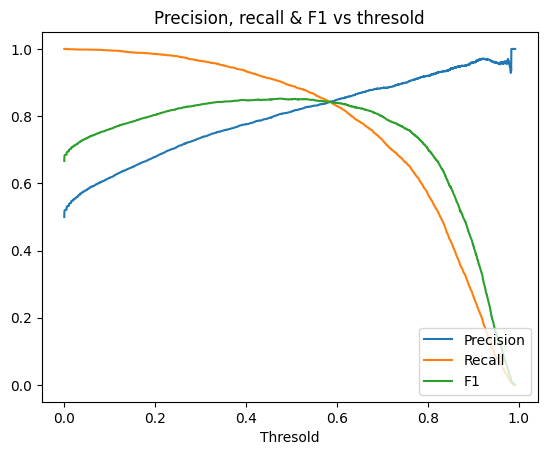

When F1 score is max 
       Precisions   Recalls        F1  Threshold
2586    0.806703  0.902953  0.852118   0.476333
Gradient boosting
************************************************
Upsampled data
accuracy  score: 0.8228505952197853
precision  score: 0.8130609066776312
recall  score: 0.8357442958738226
f1  score: 0.8202252274505956
neg_log_loss  score: -0.38581815131910757


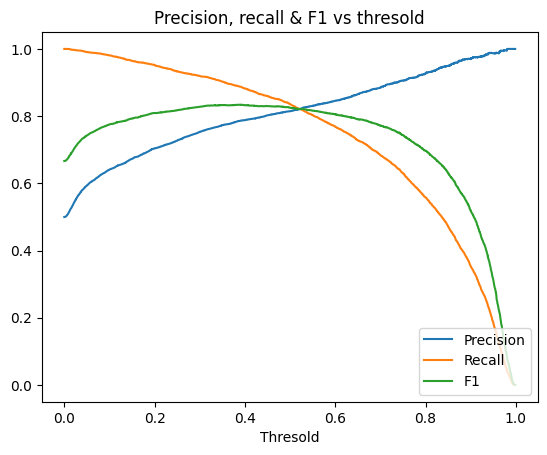

When F1 score is max 
       Precisions   Recalls        F1  Threshold
3580     0.78691  0.887464  0.834167   0.391256
Decision Trees
************************************************
Upsampled data
accuracy  score: 0.7820682624152433
precision  score: 0.7603031725573619
recall  score: 0.8226332231496908
f1  score: 0.7898886835344923
neg_log_loss  score: -0.4828353672783562


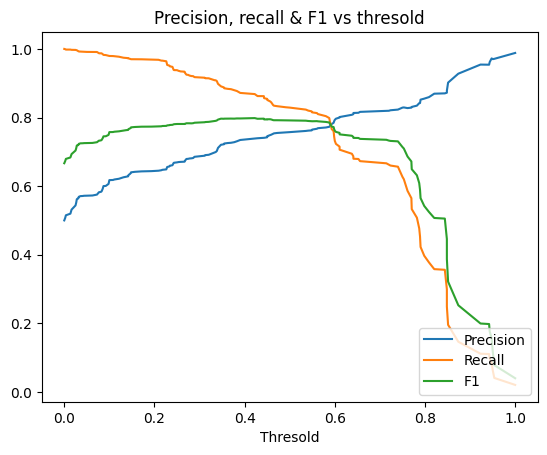

When F1 score is max 
     Precisions   Recalls        F1  Threshold
81    0.738728  0.868345  0.798309   0.422414


In [28]:
clsLR_sm = LogisticRegression(random_state = random_state
                           , C = 10
                           , penalty = 'l2')

clsRF_sm = RandomForestClassifier(random_state = random_state
                               , max_depth = 15
                              , n_estimators = 200
                              , max_features = 'log2'
                              , min_samples_leaf = 1 )

clsGB_sm = GradientBoostingClassifier(random_state = random_state
                              , max_depth = 7
                              , n_estimators = 100
                              , learning_rate = 0.2
                              , min_samples_leaf = 5
                              , min_samples_split = 0.1
                              , subsample = 1)

clsDT_sm = DecisionTreeClassifier(min_samples_split = 2
                               , min_samples_leaf = 20
                               , max_features = None
                               , max_depth = 5
                               , criterion = 'gini')

clsModels_sm = [clsLR_sm, clsRF_sm, clsGB_sm, clsDT_sm]

Cross_validation_score(clsModels_sm, clsModelsNm, [(x_train_sm, y_train_sm,'Upsampled data')], scoreMatrix)

In [29]:
def Cus_log_loss(target, predicted):
    if len(predicted) != len(target):
        print("Data object initiated")
        return

    target = [float(x) for x in target] # converting target into float
    predicted = [min([max([x,1e-15]), 1-1e-15]) for x in predicted]

    return -1.0 / len(target) *  sum([ target[i] * math.log(predicted[i]) + (1.0 - target[i]) * math.log(1.0 - predicted[i])
                                      for i in range(len(predicted))])

def Model_evaluation(models, clsModelsNm, x_train, y_train, x_test, y_test,  threshold ):

    predicted_val = {}
    for i, model in enumerate(clsModelsNm):
        models[i].fit(x_train,y_train)
        predicted_proba = models[i].predict_proba(x_test)

        predicted = predicted_proba[:,1].copy()
        predicted[predicted >=threshold[i]] = 1
        predicted[predicted < threshold[i]] = 0

        confusion_matrix_matrix = metrics.confusion_matrix(y_true = y_test
                                                   ,y_pred = predicted
                                                   #,normalize = 'true'
                                                   )

        print("***********",clsModelsNm[i], "*************")
        print(metrics.classification_report(y_test, predicted))
        print("*******************************************")
        #print("Log loss score", round(metrics.log_loss(y_test,models[i].predict_proba(x_test)[:,1]),2))
        print("Log loss score", round(Cus_log_loss(y_test,predicted_proba[:,1]),2))
        print("*******************************************")
        print("Confusion matrix")
        sns.heatmap(confusion_matrix_matrix
                    , annot=True
                    , fmt="d"
                   )
        plt.xlabel("Predicted label")
        plt.ylabel("Actual label")
        plt.show()
        print("*******************************************")

        predicted_val[model] = predicted

*********** Logistic Regression *************
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1042
           1       0.55      0.77      0.64       367

    accuracy                           0.77      1409
   macro avg       0.73      0.77      0.74      1409
weighted avg       0.81      0.77      0.78      1409

*******************************************
Log loss score 0.41
*******************************************
Confusion matrix


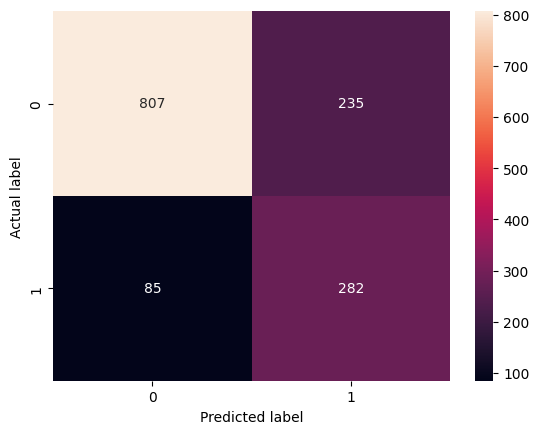

*******************************************
*********** Random Forest *************
              precision    recall  f1-score   support

           0       0.90      0.78      0.84      1042
           1       0.55      0.75      0.64       367

    accuracy                           0.78      1409
   macro avg       0.73      0.77      0.74      1409
weighted avg       0.81      0.78      0.78      1409

*******************************************
Log loss score 0.4
*******************************************
Confusion matrix


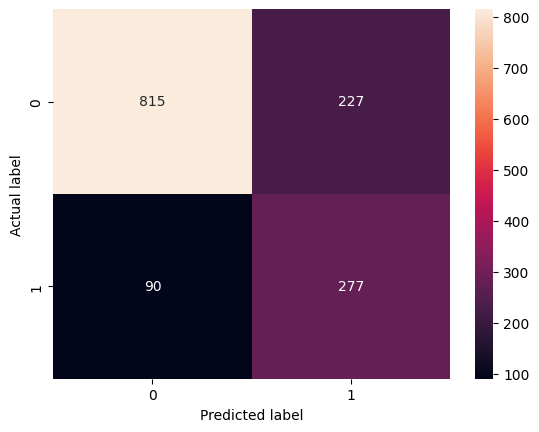

*******************************************
*********** Gradient boosting *************
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1042
           1       0.58      0.69      0.63       367

    accuracy                           0.79      1409
   macro avg       0.73      0.76      0.74      1409
weighted avg       0.80      0.79      0.80      1409

*******************************************
Log loss score 0.4
*******************************************
Confusion matrix


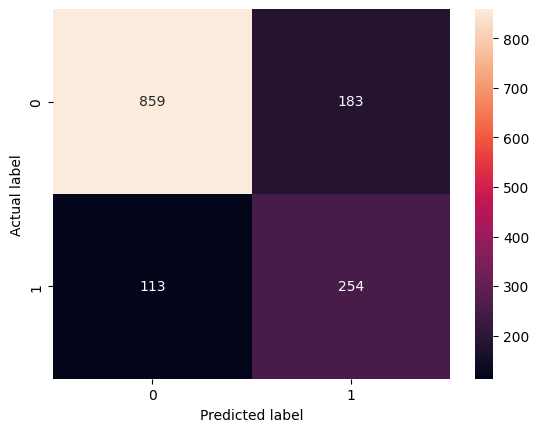

*******************************************
*********** Decision Trees *************
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1042
           1       0.51      0.78      0.62       367

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.75      0.76      1409

*******************************************
Log loss score 0.42
*******************************************
Confusion matrix


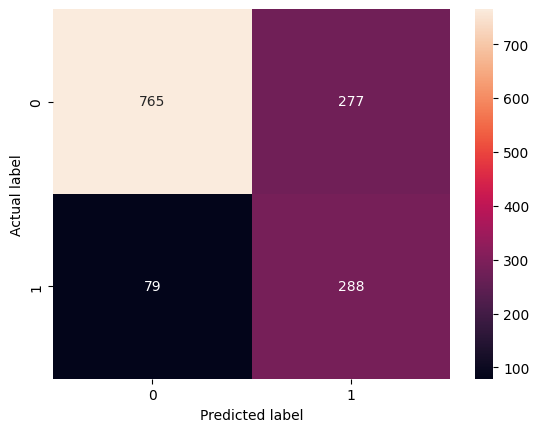

*******************************************


In [30]:
Logistic_threshold = 0.30
Random_forest_threshold = 0.32
Gradient_boosting_threshold = 0.36
Decision_Tree_threshold = 0.38

Model_evaluation(clsModels
                 , clsModelsNm
                 , x_train
                 , y_train
                 , x_test
                 , y_test
                 , [Logistic_threshold
                    ,Random_forest_threshold
                    , Gradient_boosting_threshold
                    , Decision_Tree_threshold] )

*********** Logistic Regression *************
              precision    recall  f1-score   support

           0       0.89      0.79      0.83      1042
           1       0.54      0.72      0.62       367

    accuracy                           0.77      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.80      0.77      0.78      1409

*******************************************
Log loss score 0.45
*******************************************
Confusion matrix


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



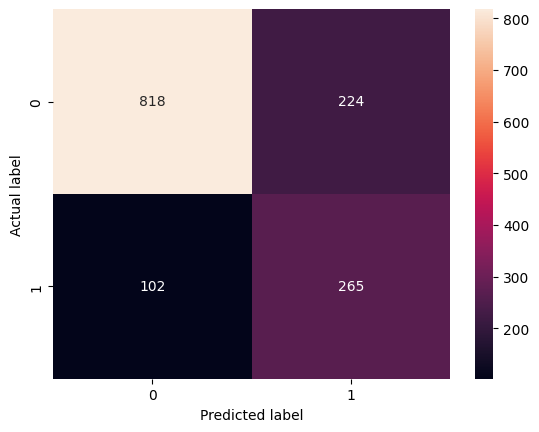

*******************************************
*********** Random Forest *************
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1042
           1       0.56      0.71      0.63       367

    accuracy                           0.78      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.78      0.79      1409

*******************************************
Log loss score 0.45
*******************************************
Confusion matrix


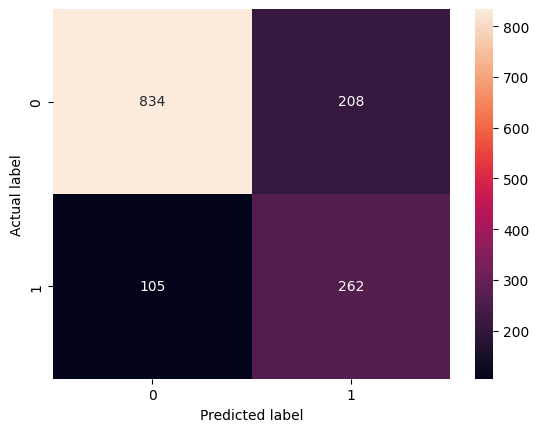

*******************************************
*********** Gradient boosting *************
              precision    recall  f1-score   support

           0       0.89      0.79      0.83      1042
           1       0.54      0.71      0.61       367

    accuracy                           0.77      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.80      0.77      0.78      1409

*******************************************
Log loss score 0.44
*******************************************
Confusion matrix


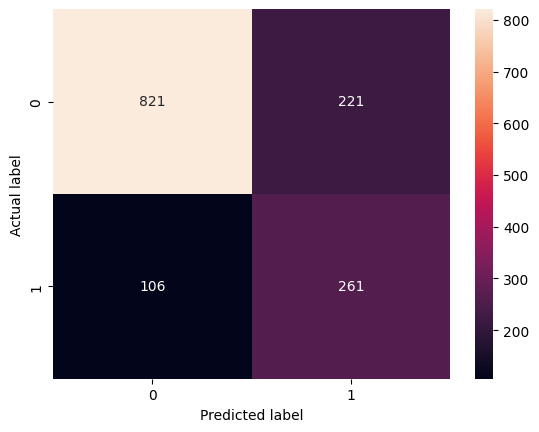

*******************************************
*********** Decision Trees *************
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1042
           1       0.49      0.81      0.61       367

    accuracy                           0.74      1409
   macro avg       0.70      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409

*******************************************
Log loss score 0.49
*******************************************
Confusion matrix


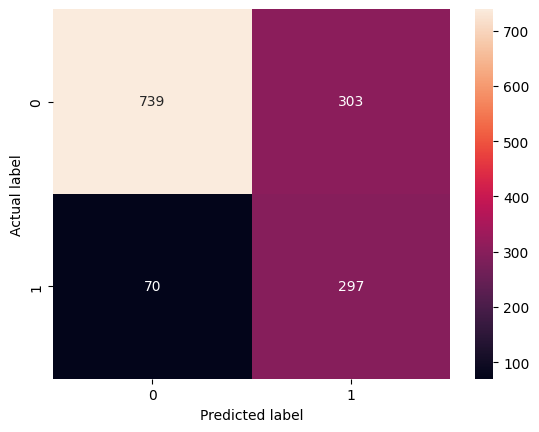

*******************************************


In [31]:
Logistic_threshold_sm = 0.46
Random_forest_threshold_sm = 0.47
Gradient_boosting_threshold_sm = 0.43
Decision_Tree_threshold_sm = 0.44

Model_evaluation(clsModels_sm
                 , clsModelsNm
                 , x_train_sm
                 , y_train_sm
                 , x_test
                 , y_test
                 , [Logistic_threshold_sm
                    ,Random_forest_threshold_sm
                    , Gradient_boosting_threshold_sm
                    , Decision_Tree_threshold_sm] )

<table>
<caption><h3>Model Log Loss Comparison</h3></caption>
<tr>
<th rowspan="2"></th>
<th colspan="2"><h4>Original Log Loss</h4></th>
<th colspan="2"><h4>Smote Log Loss</h4></th>
</tr>
<tr>
<th>Train</th>
<th>Test</th>
<th>Train</th>
<th>Test</th>
</tr>
<tr>
<td>Logistic Regression</td>
<td>0.42</td>
<td>0.40</td>
<td>0.40</td>
<td>0.45</td>
</tr>
<tr>
<td>Random Forest</td>
<td>0.41</td>
<td>0.40</td>
<td>0.36</td>
<td>0.45</td>
</tr>
<tr>
<td>Gradient Boosting</td>
<td>0.41</td>
<td>0.40</td>
<td>0.39</td>
<td>0.45</td>
</tr>
<tr>
<td>Decision Tree</td>
<td>0.44</td>
<td>0.48</td>
<td>0.49</td>
<td>0.49</td>
</tr>
</table>

In [32]:
explainer = shap.TreeExplainer(clsGB)
shap_values = explainer.shap_values(x_train)

# Compute mean absolute SHAP value for each feature
feature_importance = pd.Series(
    np.abs(shap_values).mean(axis=0),
    index=x_train.columns
).sort_values(ascending=True)  # ascending for horizontal plot

# Plotly horizontal bar chart
fig = px.bar(
    feature_importance,
    x=feature_importance.values,
    y=feature_importance.index,
    orientation="h",
    labels={"x": "Absolute SHAP Value ", "y": "Features "},
    title="Feature Importance (SHAP)"
)

fig.update_layout(
    title_font_size=16,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    bargap=0.4,
    height=1000,
    width=1200
)

fig.show()

In [33]:
churn_customer_prob = pd.DataFrame({'Predicted_proba': clsGB.predict_proba(x_test)[:][:,1]
                                   , 'predicted': clsGB.predict(x_test)})
churn_customer_prob

,Predicted_proba,predicted
0,0.147840,0
1,0.085568,0
2,0.498523,0
3,0.840966,1
4,0.055068,0
...,...,...
1404,0.073744,0
1405,0.375001,0
1406,0.009310,0
1407,0.283026,0


In [34]:
# Step 1: Merge dataframe with selected features
features = [categorical_col, numerical_col, target_col]
merged_df = pd.DataFrame()
for feature in features:
    merged_df = pd.concat([merged_df, df_model[feature]], axis=1)

# Step 2: Shuffle the data
merged_df = shuffle(merged_df).reset_index(drop=True)

# Step 3: One-hot encode nominal columns
merged_df = pd.concat([merged_df, pd.get_dummies(merged_df[nominal_col])], axis=1)
# merged_df.drop(nominal_col, axis=1, inplace=True) # Drop after splitting

# Extract existing customers before dropping nominal columns
existing_cust_data = merged_df[merged_df['Churn']==0].copy()

# Step 4: Normalize numerical columns (using existing_cust_data)
for col in numerical_col:
    existing_cust_data[col] = skp.StandardScaler().fit_transform(existing_cust_data[[col]])

# Drop nominal columns from existing_cust_data
existing_cust_data.drop(nominal_col, axis=1, inplace=True)

# Step 5: Split features and target
feature_cols = existing_cust_data.columns.difference([target_col])
existing_cust_feature = existing_cust_data[feature_cols]
existing_cust_target = existing_cust_data[target_col].values.flatten()

In [35]:
existing_customer_churn_prob = clsGB.predict_proba(existing_cust_feature)
existing_cust_data['Churn_proba'] = existing_customer_churn_prob[:,1]
existing_cust_data.head()

,Partner,Dependents,SeniorCitizen,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,InternetServiceType_Fiber optic,InternetServiceType_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,ContractType_Month-to-month,ContractType_One year,ContractType_Two year,Churn_proba
0,0,0,0,1,1,1,1,1,0,0,...,False,False,True,False,False,False,True,False,False,0.113258
1,1,0,0,1,0,0,0,0,1,0,...,False,False,False,False,False,True,False,True,False,0.054548
2,1,1,0,1,0,1,0,0,1,1,...,False,False,False,True,False,False,False,False,True,0.013556
3,0,0,0,1,1,0,1,1,0,1,...,True,False,False,False,True,False,False,True,False,0.260414
4,1,0,0,1,0,1,0,0,1,0,...,False,False,False,False,False,True,False,False,True,0.084014


In [36]:
fig = px.histogram(existing_cust_data,
                   x='Churn_proba',
                   nbins=10,  # same as bins=10
                   title="Existing customers' Churn probability distribution")

fig.update_layout(
    xaxis_title="Probability of Churn",
    yaxis_title="Customers",
    title_font_size=14,
    xaxis_title_font_size=13,
    yaxis_title_font_size=13
)

fig.show()

In [37]:
existing_cust_data.loc[(existing_cust_data['Churn_proba'] >= 0.6), 'Risk_type'] = 'High'
existing_cust_data.loc[(existing_cust_data['Churn_proba'] >= 0.4) & (existing_cust_data['Churn_proba'] < 0.6) , 'Risk_type'] = 'Medium'
existing_cust_data.loc[(existing_cust_data['Churn_proba'] < 0.4) , 'Risk_type'] = 'Low'

existing_cust_data['Risk_type'].value_counts()

,count
Risk_type,
Low,4282
Medium,543
High,349


In [38]:
fig = px.bar(
    existing_cust_data['Risk_type'].value_counts().reset_index(),
    x='count',  # counts
    y='Risk_type',      # categories
    orientation='h',
    title="Existing customer risk type distribution",
    labels={'Risk_type': 'Risk type', 'Count': 'Customers'}
)

fig.update_layout(
    title_font_size=14,
    xaxis_title="Customers",
    yaxis_title="Risk type",
    xaxis_title_font_size=13,
    yaxis_title_font_size=13
)

fig.show()

## Conclusion

In this notebook, I have approached the customer churn prediction problem systematically, breaking it down into distinct stages: data exploration, customer profiling, clustering, model selection & evaluation, and finally, the formulation of retention strategies.

1. <b>Exploration & Profiling:</b><br>
The first step was to understand the data distribution, key patterns, and correlations across customer attributes such as tenure, monthly charges, and service usage. Profiling helped in identifying which segments of customers are more vulnerable to churn, for example, short-tenure customers or those with higher monthly charges.

2. <b>Model Selection & Evaluation:</b><br>
Multiple classification models were trained and evaluated using metrics such as accuracy, F1 score, and log loss. Log loss, in particular, was emphasized because it captures the confidence of predictions and penalizes incorrect probabilities, which is essential for understanding churn uncertainty. Threshold tuning was applied to balance precision and recall based on business priorities (e.g., minimizing false negatives to avoid losing high-value customers).

3. <b>Retention Planning:</b><br>
Once high-risk churn customers were identified, actionable retention strategies can be designed. For example, offering discounts, loyalty rewards, or personalized support for at-risk customers identified through the model.

4. <b>Additional Data Sources:</b><br>
To further improve model accuracy, additional data sources could be incorporated such as:
  <ul><ul>
  - Customer inquiries and complaints (sentiment and frequency of support requests)<br>
  - Seasonality in sales and service usage trends<br>
  - Broader demographic information (age, income, geographic patterns)<br>
  - Engagement data such as app usage frequency, product adoption rate, and feedback surveys</ul></ul>

5. <b>Cohort Analysis (added dimension):</b><br>
Cohort analysis can significantly enrich churn understanding by tracking groups of customers (cohorts) who started in the same time period and observing their retention behavior over time. This helps in identifying:
<ul><ul>
- At what stage customers are most likely to churn (e.g., after the 3rd month of subscription).<br>

- Which acquisition channels bring in customers with higher long-term retention.<br>
</ul></ul><br>
Whether product or policy changes improve churn rates across cohorts.
Cohort analysis complements churn modeling by providing a time-based perspective on customer lifecycles, enabling retention teams to design interventions that address churn at the right stage.